# 2. Geophysics NetCDF Grid Data Utilities Demonstration
### TODO: Needs fixing to work with datasets >5MB of data
### Edge detection also suspect for this dataset - need to check
Demonstrates edge detection and transect across grid. Plots data.

In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import get_netcdf_edge_points, points2convex_hull
import matplotlib.pyplot as plt

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'    

In [4]:
# Open netCDF4 Dataset
netcdf_path = "/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"
if not os.path.isfile(netcdf_path):
    netcdf_path = "https://dapds00.nci.org.au//thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"

netcdf_dataset = netCDF4.Dataset(netcdf_path, 'r')

max_bytes = 500000000 # Set this to something lower that the NCI OPeNDAP request size limit of 5MB

netcdf_grid_utils = NetCDFGridUtils(netcdf_dataset)
#netcdf_grid_utils.__dict__

/srv/conda/envs/notebook/lib/python3.10/site-packages/osgeo/osr.py:385: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
# Find edge points
# Note that we would normally use netcdf2convex_hull to go straight to the convex hull, but we want to plot the points
edge_points = np.array(get_netcdf_edge_points(netcdf_dataset, max_bytes=max_bytes))
print(edge_points.shape)

(92144, 2)


In [6]:
# Compute convex hull
# Note that we would normally use netcdf2convex_hull to go straight to the convex hull, but we want to plot the edge points
avg_pixel_size = (netcdf_grid_utils.pixel_size[0] + netcdf_grid_utils.pixel_size[1]) / 2.0
convex_hull = np.array(points2convex_hull(edge_points, avg_pixel_size, avg_pixel_size))
print(convex_hull.shape)

(6, 2)


In [7]:
# Obtain coordinates for sample points along transect
# Note that sample points between vertices are computed in UTM space for linear metres

#transect_vertices = ((110, -25), (155, -25))
#transect_vertices = ((110, -25), (115, -25), (120, -25), (125, -25), (130, -25), (135, -25), (140, -25), (145, -25), (150, -25), (155, -25))
transect_vertices = ((110, -25), (115, -25.5), (120, -26), (125, -26.5), (130, -27), (135, -27.5), (140, -28), (145, -28.5), (150, -29), (155, -29.5))

sample_points, sample_spacing = netcdf_grid_utils.sample_transect(transect_vertices, 'EPSG:4326')
print(sample_spacing)
sample_points = np.array(sample_points)
print(sample_points.shape)
print(sample_points)

500
(9168, 2)
[[110.         -25.        ]
 [110.00453705 -25.00053674]
 [110.00907428 -25.00107336]
 ...
 [154.98632651 -29.49892909]
 [154.99122575 -29.49931299]
 [154.99612491 -29.49969667]]


In [8]:
# Obtain values for sample points
sample_values = np.array(netcdf_grid_utils.get_value_at_coords(sample_points, 'EPSG:4326', max_bytes=100))
print(sample_values.shape)

(9168,)


In [9]:
# Disregard any values outside data area
no_data_value = netcdf_grid_utils.data_variable._FillValue
print(f'no_data_value = {no_data_value}')
good_data_mask = sample_values != no_data_value

good_sample_points = sample_points[good_data_mask]
print(f'good_sample_points = {len(good_sample_points)}')
bad_sample_points = sample_points[~good_data_mask]
print(f'bad_sample_points = {len(bad_sample_points)}')

sample_values[~good_data_mask] = np.NaN

no_data_value = -99999.0
good_sample_points = 9168
bad_sample_points = 0


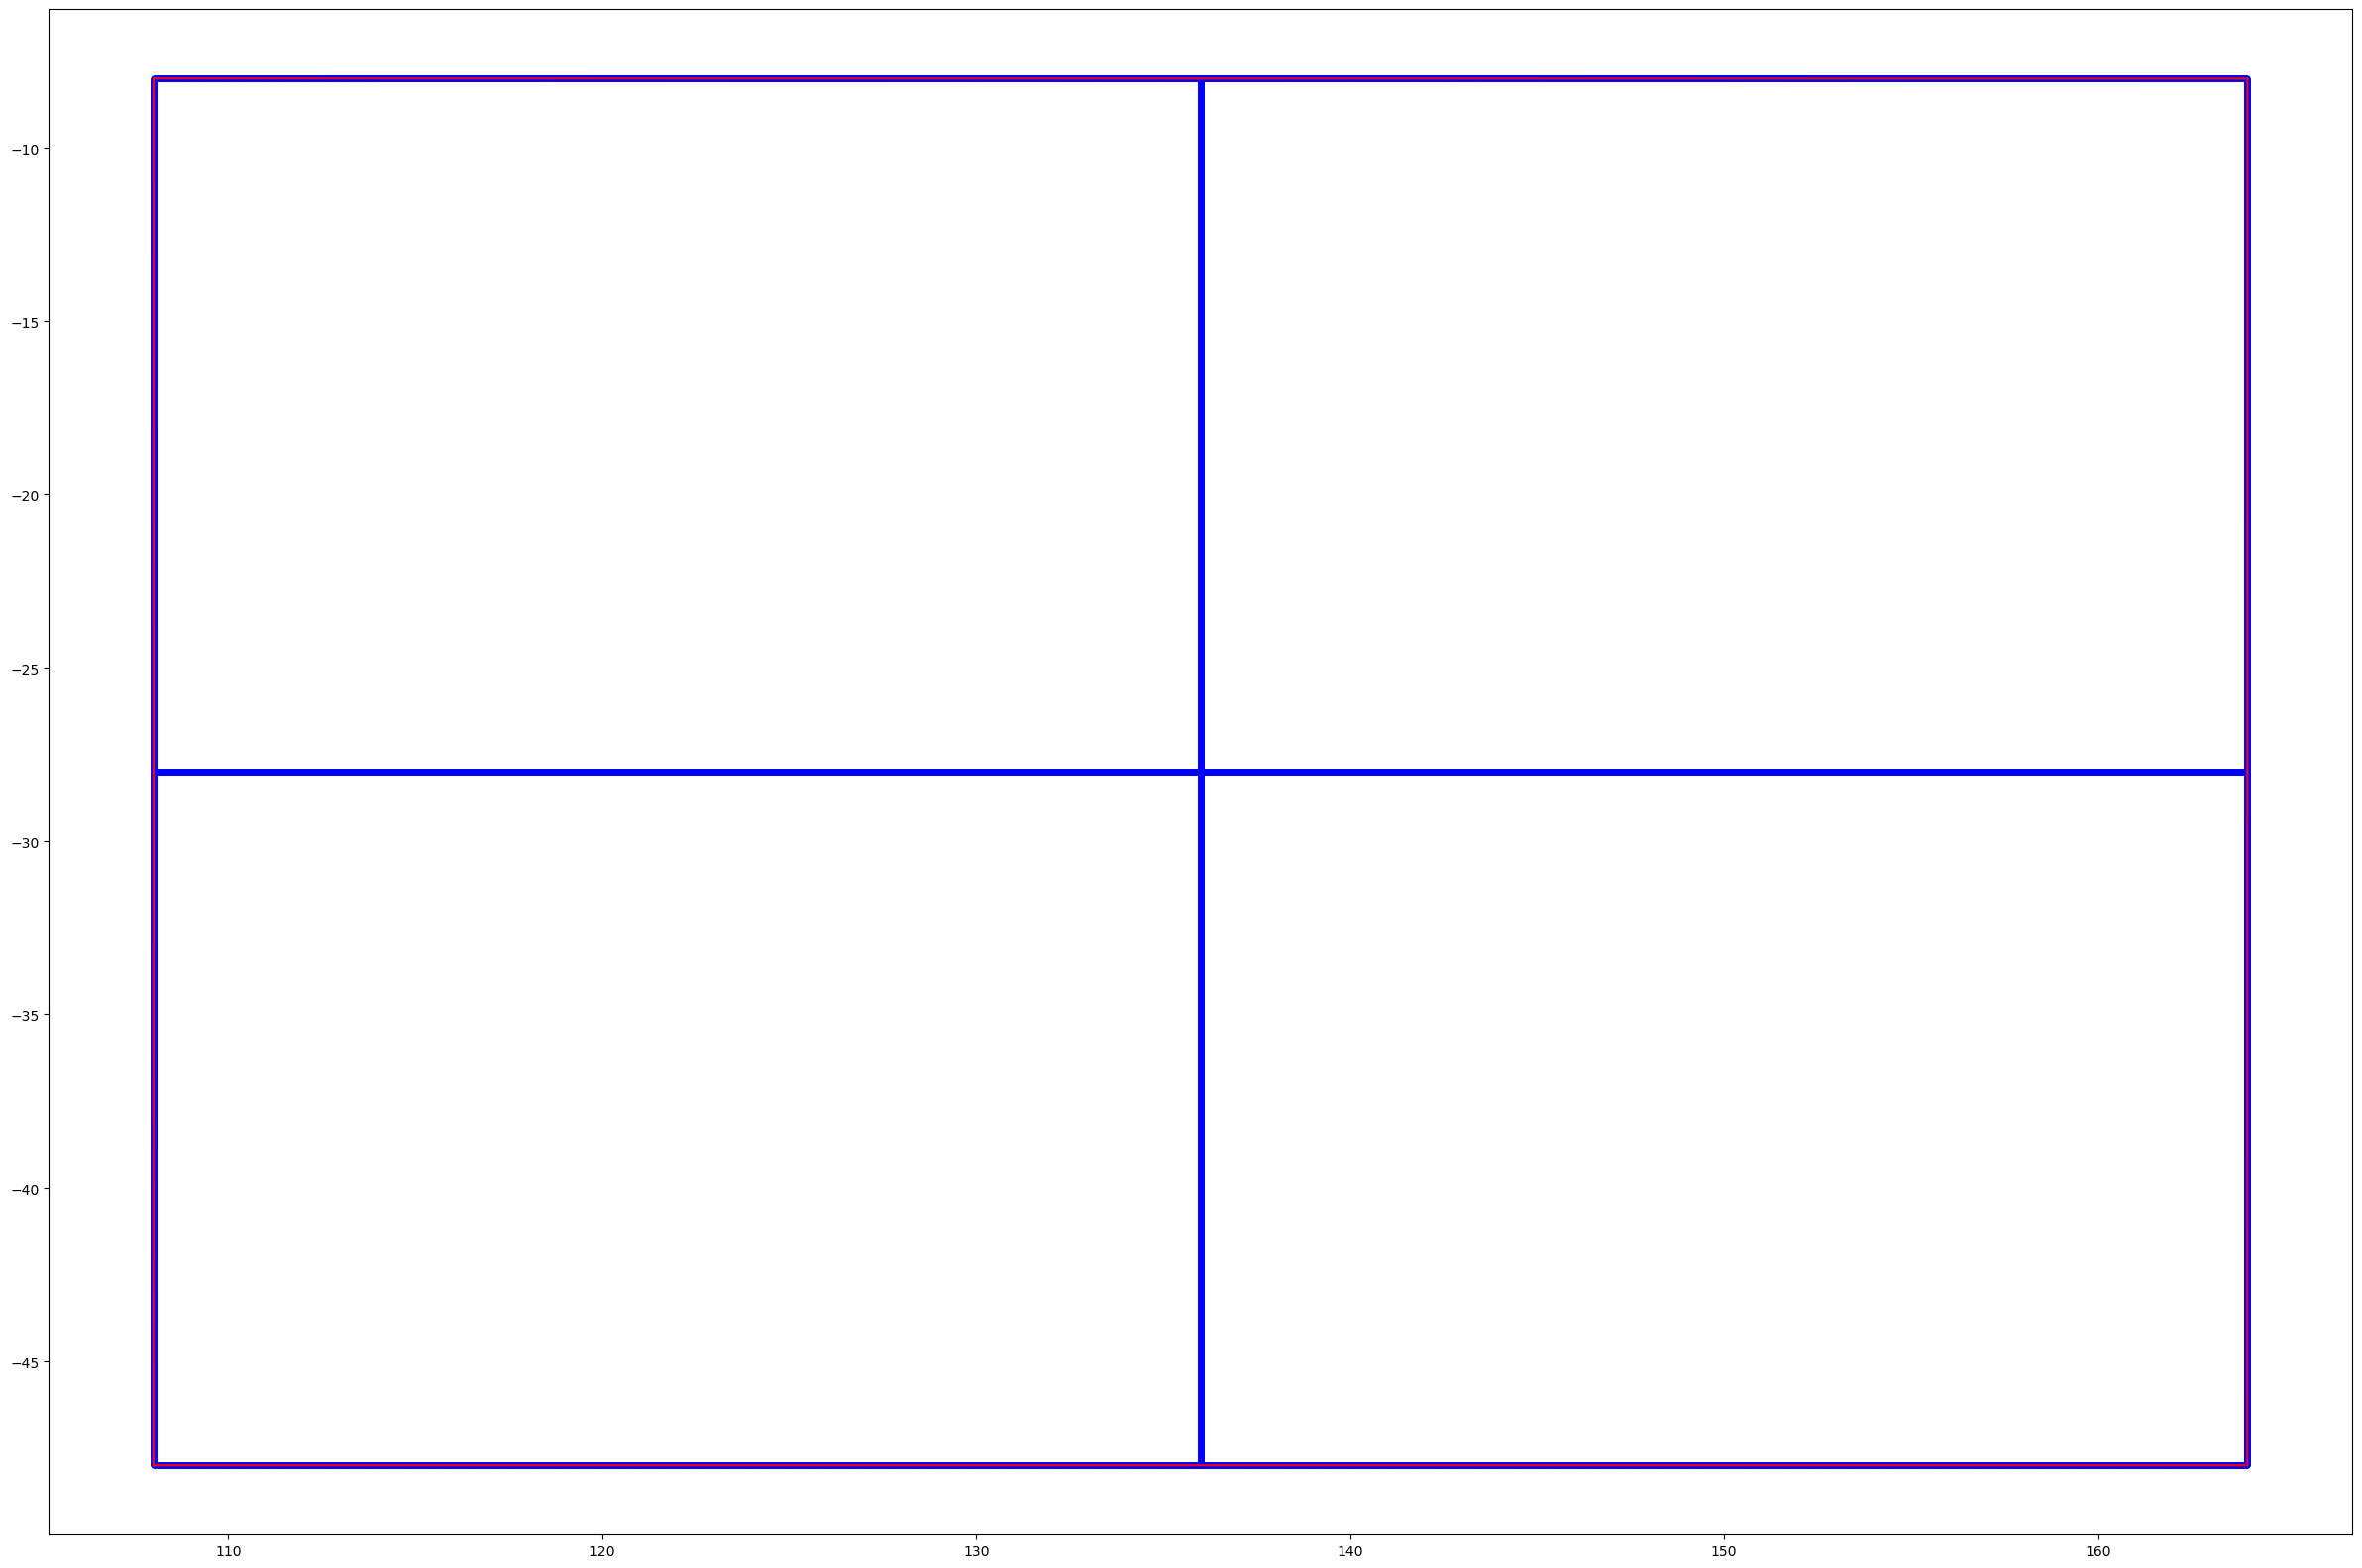

In [10]:
# Plot good and bad data points
plt.figure(figsize=(30,20))    
plt.plot(edge_points[:,0], edge_points[:,1], 'b.')
#plt.plot(good_sample_points[:,0], good_sample_points[:,1], 'g.')
#plt.plot(bad_sample_points[:,0], bad_sample_points[:,1], 'r.')
plt.plot(convex_hull[:,0], convex_hull[:,1], 'r-')

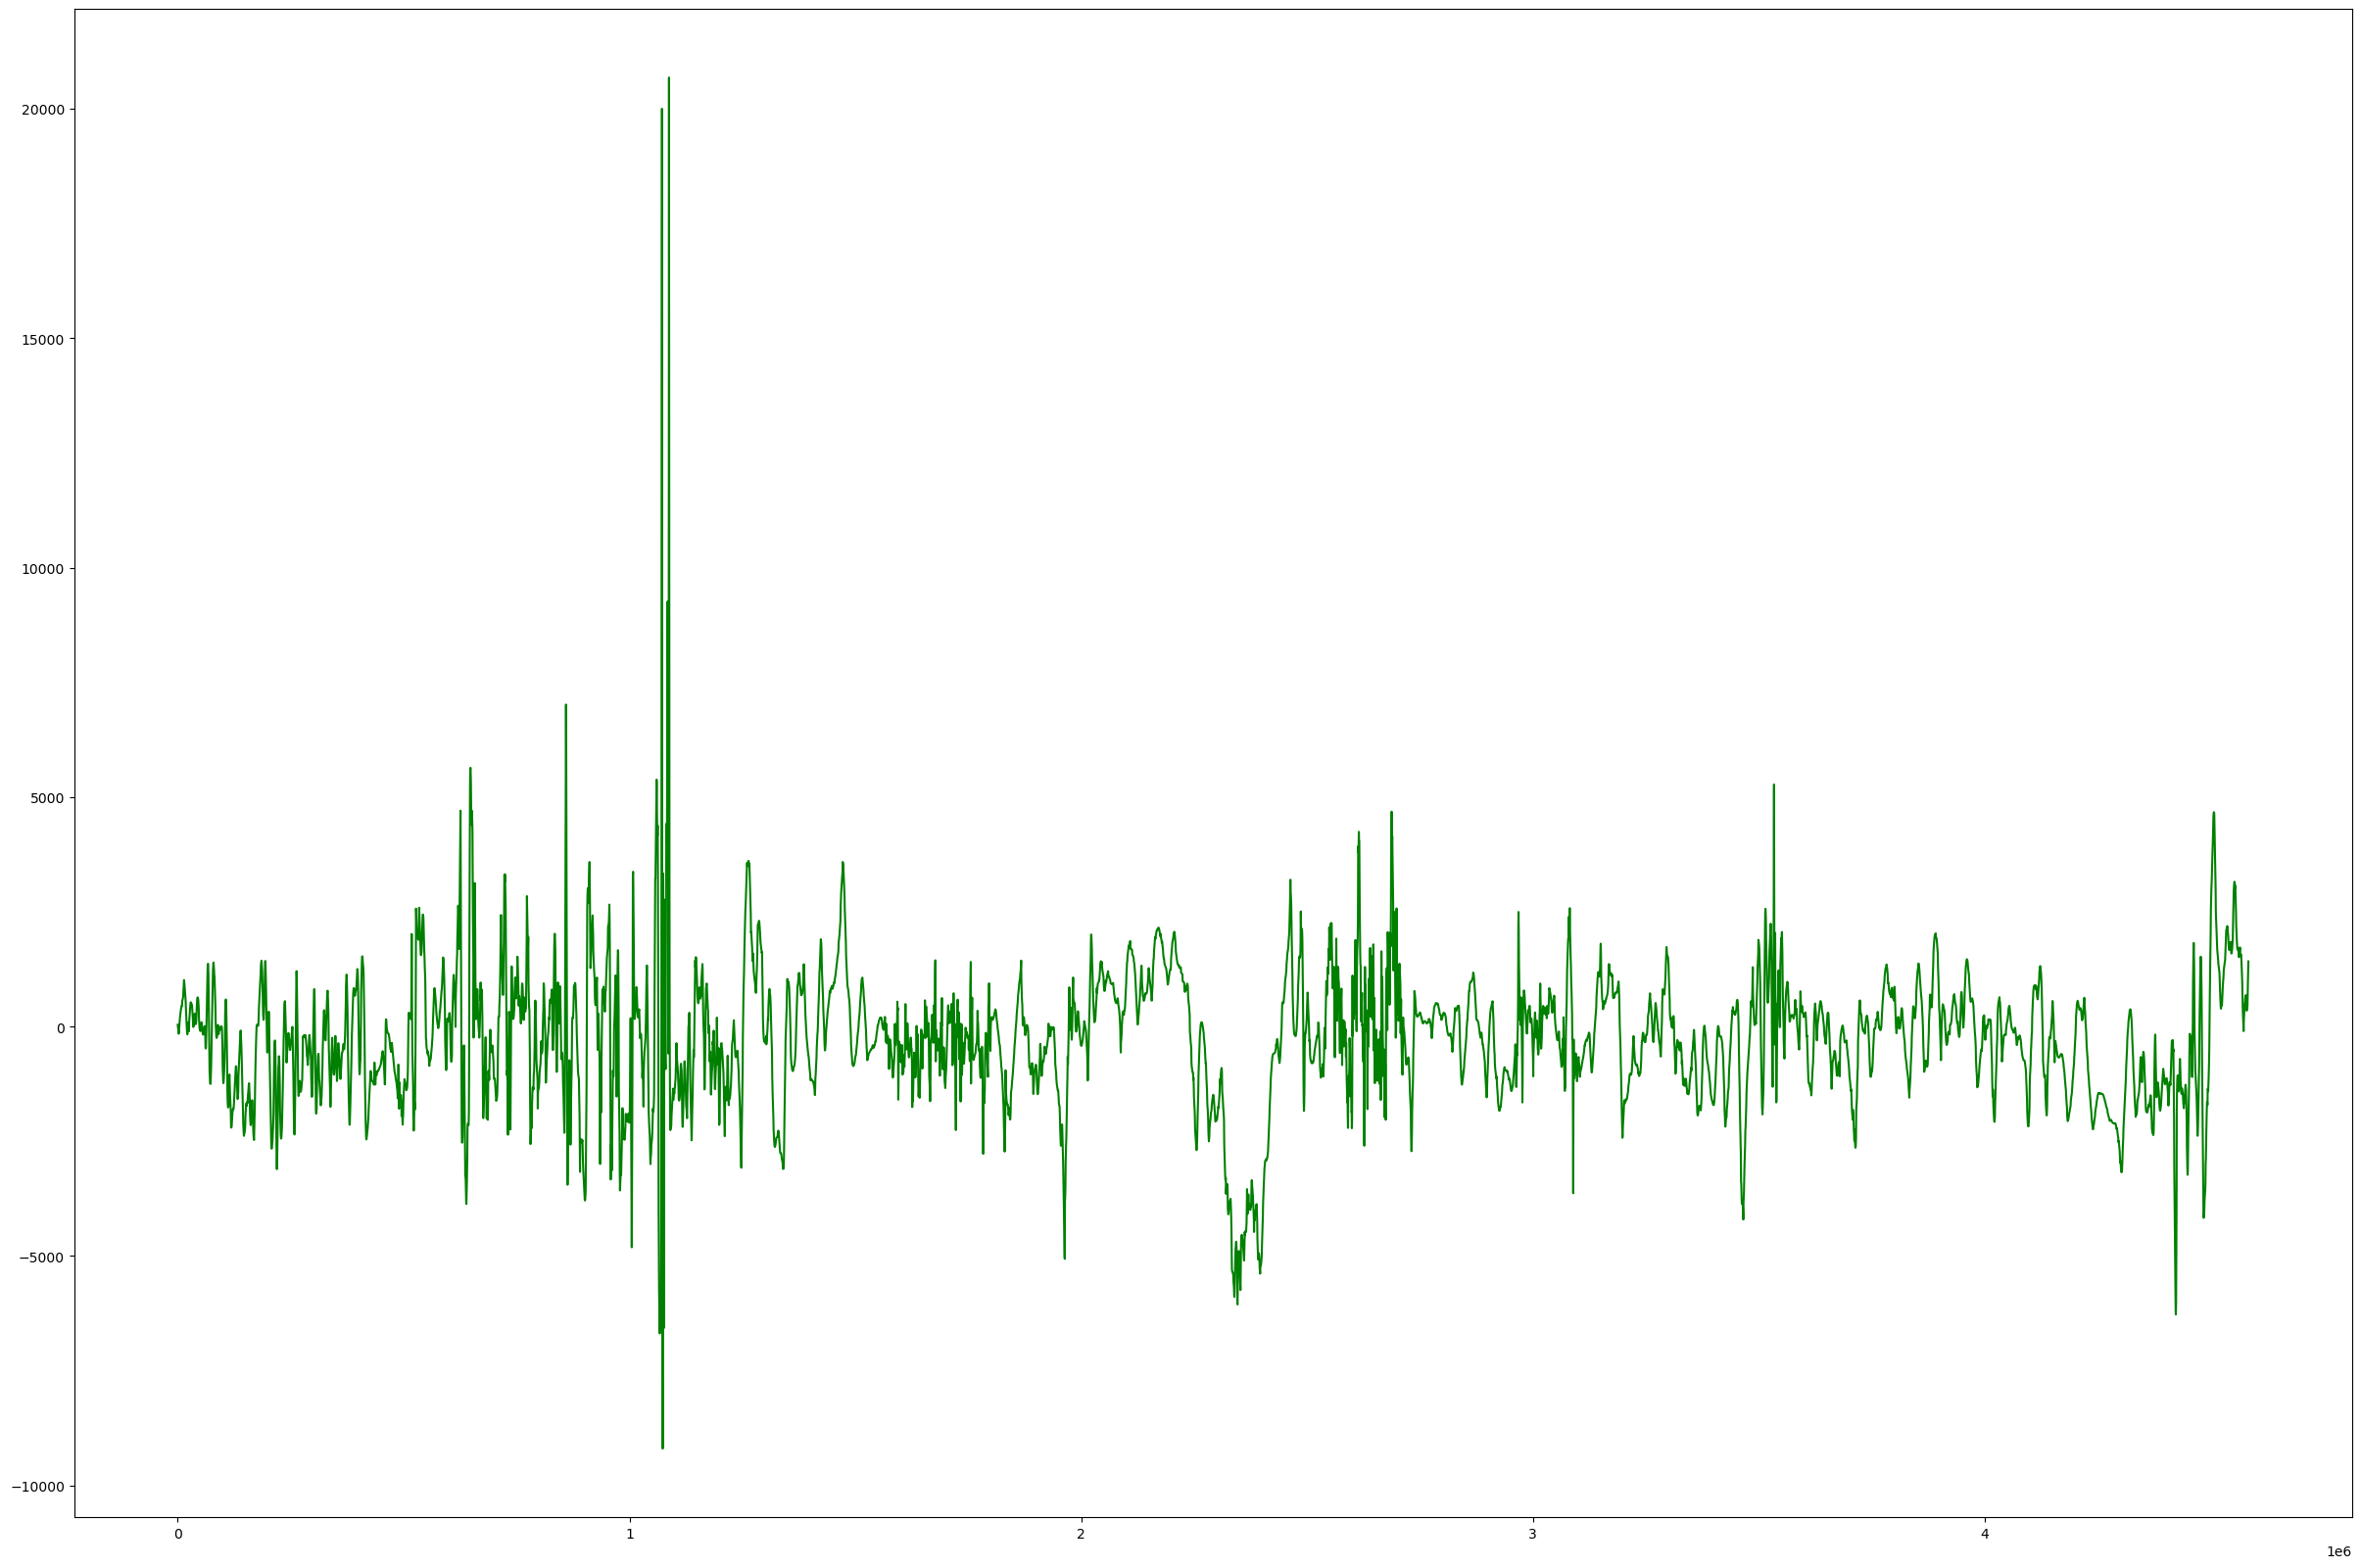

In [11]:
# Plot values against distance along transect
if sample_spacing >= 1000:
    x_increment = int(sample_spacing / 1000) # convert from m to km
else:
    x_increment = int(sample_spacing)
plt.figure(figsize=(30,20))    
plt.plot(range(0,len(sample_values) * x_increment, x_increment), sample_values, 'g-') # Show x in km

In [12]:
# Plot actual grid data
plt.figure(figsize=(30,20))  
if netcdf_grid_utils.y_inverted:
    plt.imshow(netcdf_grid_utils.data_variable[:], cmap='Spectral_r') # Do NOT invert Y axis for conventional image
else:
    plt.imshow(netcdf_grid_utils.data_variable[::-1,:], cmap='Spectral_r') # Invert Y axis for conventional image    


oc_open: server error retrieving url: code=403 message="Request too big=516.188164 Mbytes, max=500.0"

RuntimeError: NetCDF: Authorization failure

<Figure size 3000x2000 with 0 Axes>